## CNN

In [81]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from keras import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten,
                          MaxPooling2D)
from keras.optimizers import Adam, Adamax
from keras_preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from utils import (load_history_from_file,
                   plot_confusion_matrix, plot_training_history, save_history,
                   )

In [25]:
sns.set_style("whitegrid")

## Data

Weather images are taken from this [source](https://data.mendeley.com/datasets/4drtyfjtfy/1).

In [26]:
dataset_dir = "dataset"

In [27]:
images_df = pd.DataFrame(columns=["filename", "label"])

images_df["filename"] = [os.path.join(os.getcwd(),dataset_dir , i) for i in os.listdir(dataset_dir)]
images_df["label"] = (images_df["filename"].str.split("\\")
               .str[-1].str.split(".")
               .str[0].str.replace("[^a-zA-Z]", "", regex=True)
)
images_df.head()

,filename,label
0,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy
1,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy
2,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy
3,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy
4,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy


In [28]:
images_df["label"].value_counts()

sunrise    357
cloudy     300
shine      253
rain       215
Name: label, dtype: int64

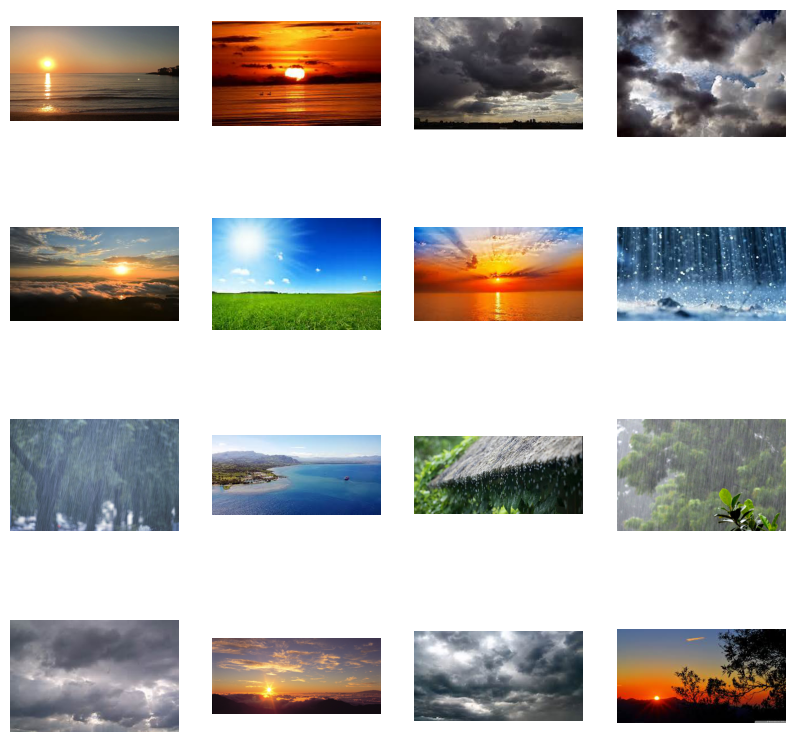

In [29]:
random_images = np.random.choice(images_df['filename'], size=16, replace=False)

fig, ax = plt.subplots(4, 4, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    img = Image.open(random_images[i])
    axi.imshow(img)
    axi.axis('off')
plt.show()

They have different shapes, so rescailing will be required.

In [30]:
train_df, test_valid_df = train_test_split(images_df, train_size=0.8, shuffle= True,
                                           random_state=30_08_2000, stratify=images_df.label)
valid_df, test_df = train_test_split(test_valid_df,  train_size= 0.6, shuffle= True, 
                                     random_state=30_08_2000, stratify=test_valid_df.label)

In [31]:
print(f"Train size: {len(train_df)}")
print(f"Valid size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

Train size: 900
Valid size: 135
Test size: 90


In [89]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [33]:
ts_length = len(test_df)
test_batch_size = 10
test_steps = ts_length // test_batch_size

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filename', y_col='label', target_size=img_size,
                                       class_mode= 'categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filename', y_col='label', target_size=img_size, 
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filename', y_col='label', target_size=img_size, 
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.


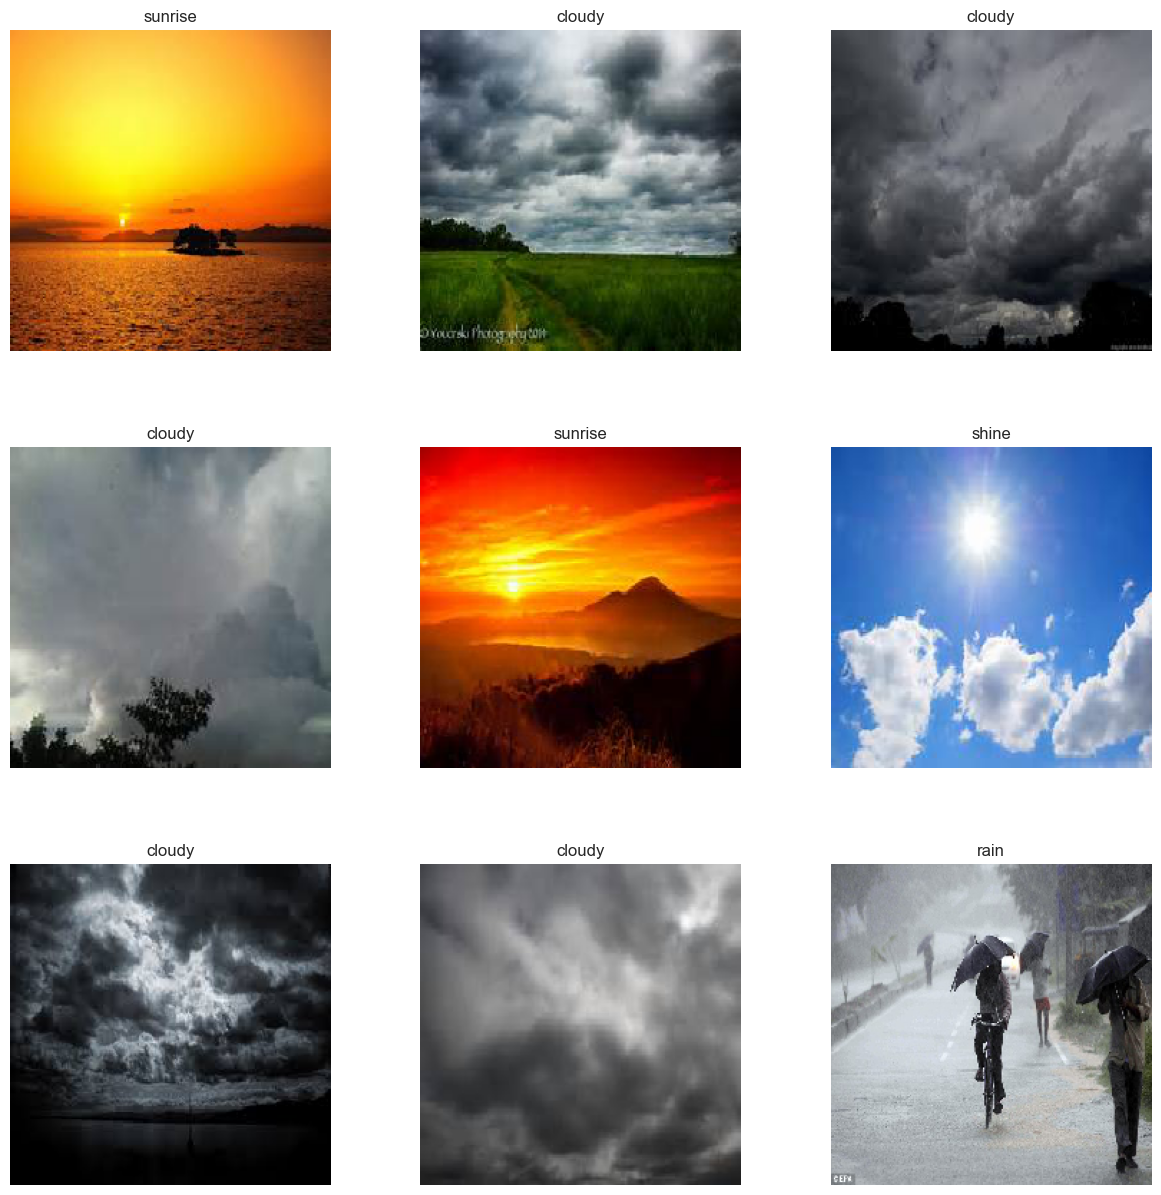

In [34]:
first_test_batch = test_gen.next()
classes_names = list(test_gen.class_indices.keys())

images, labels = first_test_batch[0], first_test_batch[1]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()
for i in range(9):
    axes[i].imshow(images[i])
    axes[i].set_title(classes_names[np.argmax(labels[i])])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.3)
plt.savefig("assets/images.png")
plt.show()

### CNN network

First, let's use Optuna to find the best hyperparameters for the CNN network.

In [25]:
def objective(trial):
    model = Sequential()

    filters_num = trial.suggest_int("filters_num", 8, 32)
    kernel_size = trial.suggest_int("kernel_size", 2, 10)
    pool_size = trial.suggest_int("pool_size", 2, 4)
    convolutional_layers_num = trial.suggest_int("convolutional_layers_num", 1, 2)
    use_batch_norm = trial.suggest_categorical("use_batch_norm", [True, False])

    model.add(Conv2D(filters=filters_num, kernel_size=kernel_size, activation='relu', input_shape=img_shape))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))

    for _ in range(convolutional_layers_num):
        model.add(Conv2D(filters=filters_num, kernel_size=3, activation='relu'))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    history = model.fit(train_gen, validation_data=valid_gen, epochs=10, verbose=0)
    return history.history["val_accuracy"][-1]

In [26]:
study = optuna.create_study(direction="maximize", study_name="CNN Hyperparameter Optimization")
study.optimize(objective, n_trials=10)

[I 2024-01-10 13:46:38,897] A new study created in memory with name: CNN Hyperparameter Optimization
[I 2024-01-10 13:50:22,835] Trial 0 finished with value: 0.5703703761100769 and parameters: {'filters_num': 30, 'kernel_size': 5, 'pool_size': 2, 'convolutional_layers_num': 2, 'use_batch_norm': True, 'learning_rate': 0.00148679741597246}. Best is trial 0 with value: 0.5703703761100769.
[I 2024-01-10 13:52:22,863] Trial 1 finished with value: 0.7481481432914734 and parameters: {'filters_num': 23, 'kernel_size': 10, 'pool_size': 3, 'convolutional_layers_num': 2, 'use_batch_norm': False, 'learning_rate': 0.004767254253207538}. Best is trial 1 with value: 0.7481481432914734.
[I 2024-01-10 13:55:13,563] Trial 2 finished with value: 0.4000000059604645 and parameters: {'filters_num': 21, 'kernel_size': 6, 'pool_size': 3, 'convolutional_layers_num': 1, 'use_batch_norm': True, 'learning_rate': 0.00017717748094955518}. Best is trial 1 with value: 0.7481481432914734.
[I 2024-01-10 13:57:53,161] T

In [27]:
study.best_params

{'filters_num': 32,
 'kernel_size': 6,
 'pool_size': 2,
 'convolutional_layers_num': 2,
 'use_batch_norm': False,
 'learning_rate': 0.0004126708188867759}

In [118]:
filters_num = 8
pool_size = (2, 2)
learning_rate = 0.0005
kernel_size = 6
filters_num = 32

epochs = 12

In [119]:
class CNN(Model):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2D(filters=filters_num, kernel_size=kernel_size, activation='relu', input_shape=img_shape)
        self.pool1 = MaxPooling2D(pool_size=pool_size)
        self.conv2 = Conv2D(filters=filters_num, kernel_size=kernel_size, activation='relu')
        self.pool2 = MaxPooling2D(pool_size=pool_size)
        self.flatten = Flatten()
        self.d1 = Dense(256, activation='relu')
        self.dropout = Dropout(0.2)
        self.d2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout(x)
        return self.d2(x)

In [120]:
model = CNN()
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

model._name = "CNN"
model.build((None, *img_shape))
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          multiple                  3488      
                                                                 
 max_pooling2d_22 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          multiple                  36896     
                                                                 
 max_pooling2d_23 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        multiple                  0         
                                                                 
 dense_38 (Dense)            multiple                  22151424

In [121]:
cnn_history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, verbose=1)

Epoch 1/12
15/15 [==============================] - 16s 952ms/step - loss: 1.4530 - accuracy: 0.5078 - val_loss: 0.7216 - val_accuracy: 0.6593
Epoch 2/12
15/15 [==============================] - 14s 931ms/step - loss: 0.6837 - accuracy: 0.7244 - val_loss: 0.5405 - val_accuracy: 0.8074
Epoch 3/12
15/15 [==============================] - 14s 888ms/step - loss: 0.4823 - accuracy: 0.8278 - val_loss: 0.4040 - val_accuracy: 0.8148
Epoch 4/12
15/15 [==============================] - 15s 982ms/step - loss: 0.4177 - accuracy: 0.8500 - val_loss: 0.2972 - val_accuracy: 0.8815
Epoch 5/12
15/15 [==============================] - 15s 983ms/step - loss: 0.3363 - accuracy: 0.8800 - val_loss: 0.4988 - val_accuracy: 0.8222
Epoch 6/12
15/15 [==============================] - 17s 1s/step - loss: 0.3072 - accuracy: 0.8889 - val_loss: 0.3063 - val_accuracy: 0.8889
Epoch 7/12
15/15 [==============================] - 18s 1s/step - loss: 0.3093 - accuracy: 0.8822 - val_loss: 0.3339 - val_accuracy: 0.9111
Epoch

In [123]:
# save_history(cnn_history.history, "cnn")
cnn_history = load_history_from_file("cnn")

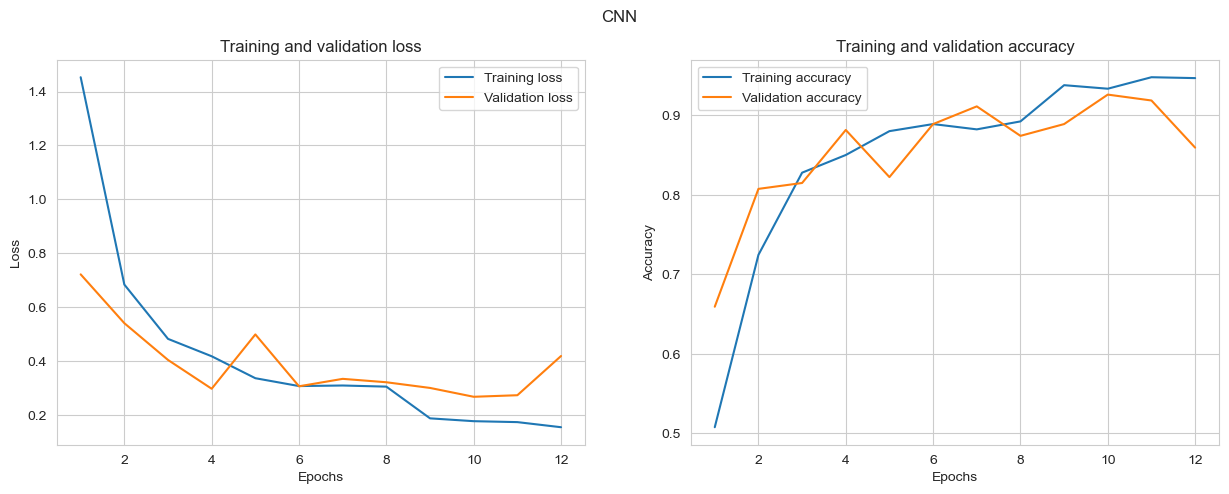

In [125]:
plot_training_history(cnn_history, "CNN")

In [126]:
cnn_test_preds = model.predict(test_gen, steps=test_steps, verbose=1)

9/9 [==============================] - 1s 63ms/step


In [127]:
cnn_test_preds = np.argmax(cnn_test_preds, axis=1)
test_labels = test_gen.classes

print(classification_report(test_labels, cnn_test_preds, target_names=classes_names))

              precision    recall  f1-score   support

      cloudy       0.81      0.92      0.86        24
        rain       0.92      0.71      0.80        17
       shine       0.91      1.00      0.95        20
     sunrise       1.00      0.97      0.98        29

    accuracy                           0.91        90
   macro avg       0.91      0.90      0.90        90
weighted avg       0.92      0.91      0.91        90



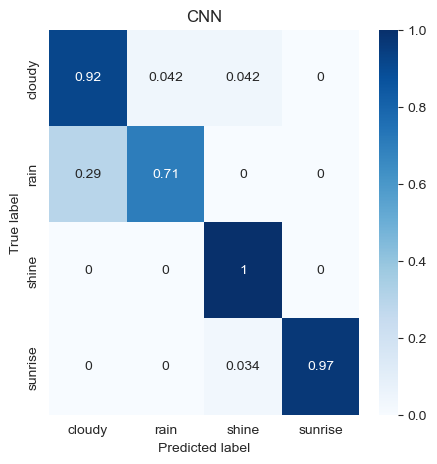

In [131]:
plot_confusion_matrix(test_labels, cnn_test_preds, "CNN", classes_names)

### Model with augmentated images

In [132]:
aug_model = CNN()
aug_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

aug_model._name = "CNN_aug"
aug_model.build((None, *img_shape))
aug_model.summary()

Model: "CNN_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          multiple                  3488      
                                                                 
 max_pooling2d_24 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          multiple                  36896     
                                                                 
 max_pooling2d_25 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        multiple                  0         
                                                                 
 dense_40 (Dense)            multiple                  2215

In [133]:
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                            zoom_range=0.2, horizontal_flip=True)

iterator = iter(train_df["filename"])

for element in iterator:
    image = Image.open(element)

    image = np.expand_dims(image, axis=0)
    try:
        aug_images = aug.flow(image, batch_size=1)
        next_aug_image = aug_images.next()
        next_aug_image = next_aug_image.astype(np.uint8)
        next_aug_image = Image.fromarray(next_aug_image[0])
        next_aug_image.save(os.path.join('augmented_images', f'aug_{os.path.basename(element)}'))
    except Exception as e:
        print(e)
        print(element)

('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (1, 453, 640))
c:\Users\Manik\projects\deep-learning-portfolio\Weather-image-classification\dataset\cloudy66.jpg
('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (1, 288, 384))
c:\Users\Manik\projects\deep-learning-portfolio\Weather-image-classification\dataset\rain141.jpg
('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (1, 360, 480))
c:\Users\Manik\projects\deep-learning-portfolio\Weather-image-classification\dataset\shine131.jpg
('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (1, 254, 600))
c:\Users\Manik\projects\deep-learning-portfolio\Weather-image-classification\dataset\cloudy71.jpg


In [134]:
aug_train_df = pd.DataFrame(columns=["filename", "label"])

aug_train_df["filename"] = [os.path.join(os.getcwd(), "augmented_images", i) for i in os.listdir("augmented_images")]
aug_train_df["label"] = (aug_train_df["filename"].str.split("_")
               .str[-1].str.split(".")
               .str[0].str.replace("[^a-zA-Z]", "", regex=True)
)

aug_train_df = pd.concat([aug_train_df, train_df], ignore_index=True)
augmentated_train_gen = ImageDataGenerator(rescale=1./255)
augmentated_train_gen = augmentated_train_gen.flow_from_dataframe(aug_train_df, x_col='filename', y_col='label', target_size=img_size,
                                                                  class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 1796 validated image filenames belonging to 4 classes.


In [135]:
aug_history = aug_model.fit(augmentated_train_gen, validation_data=valid_gen, epochs=epochs, verbose=1)

Epoch 1/12
29/29 [==============================] - 35s 1s/step - loss: 1.3688 - accuracy: 0.5395 - val_loss: 0.5545 - val_accuracy: 0.7852
Epoch 2/12
29/29 [==============================] - 29s 1s/step - loss: 0.6235 - accuracy: 0.7567 - val_loss: 0.4428 - val_accuracy: 0.7630
Epoch 3/12
29/29 [==============================] - 30s 1s/step - loss: 0.4661 - accuracy: 0.8202 - val_loss: 0.3184 - val_accuracy: 0.8667
Epoch 4/12
29/29 [==============================] - 31s 1s/step - loss: 0.3946 - accuracy: 0.8452 - val_loss: 0.2733 - val_accuracy: 0.8593
Epoch 5/12
29/29 [==============================] - 28s 937ms/step - loss: 0.3252 - accuracy: 0.8825 - val_loss: 0.3124 - val_accuracy: 0.8963
Epoch 6/12
29/29 [==============================] - 28s 951ms/step - loss: 0.3281 - accuracy: 0.8775 - val_loss: 0.3635 - val_accuracy: 0.8519
Epoch 7/12
29/29 [==============================] - 30s 1s/step - loss: 0.3069 - accuracy: 0.8825 - val_loss: 0.3999 - val_accuracy: 0.8444
Epoch 8/12
29/

In [136]:
# save_history(aug_history.history, "aug")
aug_history = load_history_from_file("aug")

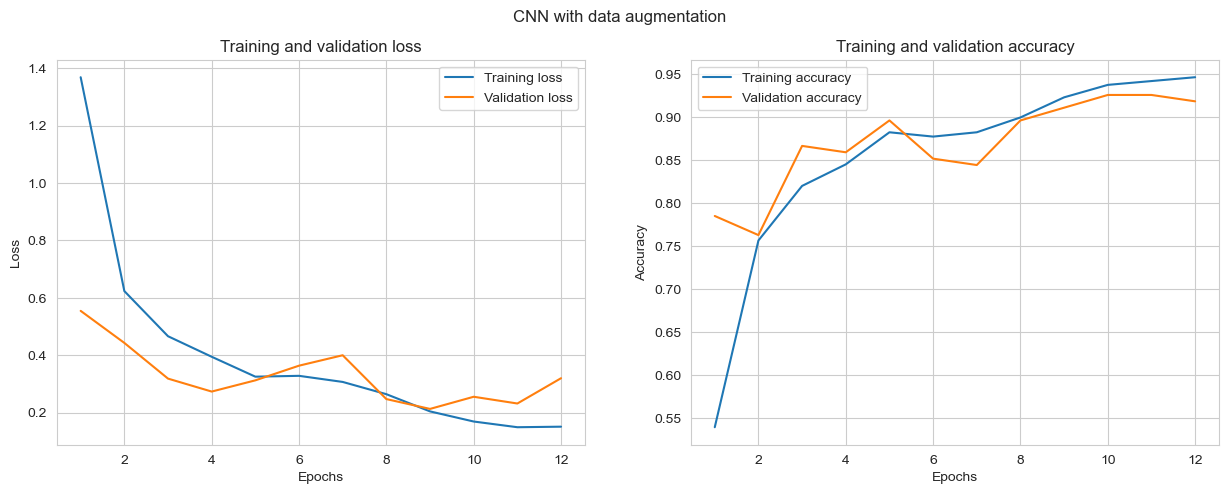

In [138]:
plot_training_history(aug_history, "CNN with data augmentation")

In [139]:
aug_preds = aug_model.predict(test_gen, steps=test_steps, verbose=1)
aug_preds = np.argmax(aug_preds, axis=1)

9/9 [==============================] - 1s 73ms/step


In [140]:
test_labels = test_gen.classes
print(classification_report(test_labels, aug_preds, target_names=classes_names))

              precision    recall  f1-score   support

      cloudy       0.95      0.88      0.91        24
        rain       0.94      0.94      0.94        17
       shine       0.91      1.00      0.95        20
     sunrise       1.00      1.00      1.00        29

    accuracy                           0.96        90
   macro avg       0.95      0.95      0.95        90
weighted avg       0.96      0.96      0.96        90



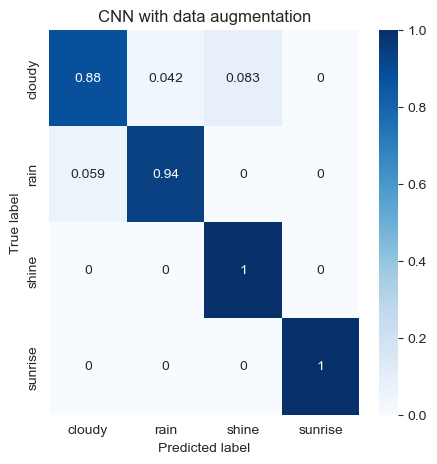

In [141]:
plot_confusion_matrix(test_labels, aug_preds, "CNN with data augmentation", classes_names)

### Using VGG16

In [142]:
class VGG16NN(Model):

    def __init__(self):
        super().__init__()
        self.vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=img_shape)
        self.flatten = Flatten()
        self.d1 = Dense(256, activation='relu')
        self.dropout = Dropout(0.2)
        self.d2 = Dense(4, activation='softmax')

        for layer in self.vgg16.layers:
            layer.trainable = False

    def call(self, x):
        x = self.vgg16(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout(x)
        return self.d2(x)

In [143]:
vgg_16_model = VGG16NN()

vgg_16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
vgg_16_model._name = "VGG16"
vgg_16_model.build((None, *img_shape))
vgg_16_model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_21 (Flatten)        multiple                  0         
                                                                 
 dense_42 (Dense)            multiple                  6422784   
                                                                 
 dropout_21 (Dropout)        multiple                  0         
                                                                 
 dense_43 (Dense)            multiple                  1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________


In [144]:
history = vgg_16_model.fit(train_gen, validation_data=valid_gen, epochs=epochs, verbose=1)

Epoch 1/12
15/15 [==============================] - 109s 7s/step - loss: 2.0817 - accuracy: 0.4933 - val_loss: 0.4847 - val_accuracy: 0.8074
Epoch 2/12
15/15 [==============================] - 111s 7s/step - loss: 0.4808 - accuracy: 0.8222 - val_loss: 0.3058 - val_accuracy: 0.9111
Epoch 3/12
15/15 [==============================] - 119s 8s/step - loss: 0.2672 - accuracy: 0.9167 - val_loss: 0.2371 - val_accuracy: 0.9407
Epoch 4/12
15/15 [==============================] - 113s 7s/step - loss: 0.1720 - accuracy: 0.9567 - val_loss: 0.2085 - val_accuracy: 0.9481
Epoch 5/12
15/15 [==============================] - 105s 7s/step - loss: 0.1236 - accuracy: 0.9733 - val_loss: 0.2025 - val_accuracy: 0.9481
Epoch 6/12
15/15 [==============================] - 103s 7s/step - loss: 0.0924 - accuracy: 0.9822 - val_loss: 0.2101 - val_accuracy: 0.9185
Epoch 7/12
15/15 [==============================] - 109s 7s/step - loss: 0.0707 - accuracy: 0.9856 - val_loss: 0.1790 - val_accuracy: 0.9556
Epoch 8/12
15

In [145]:
# save_history(history.history, "vgg_16")
vgg_16_history = load_history_from_file("vgg16")

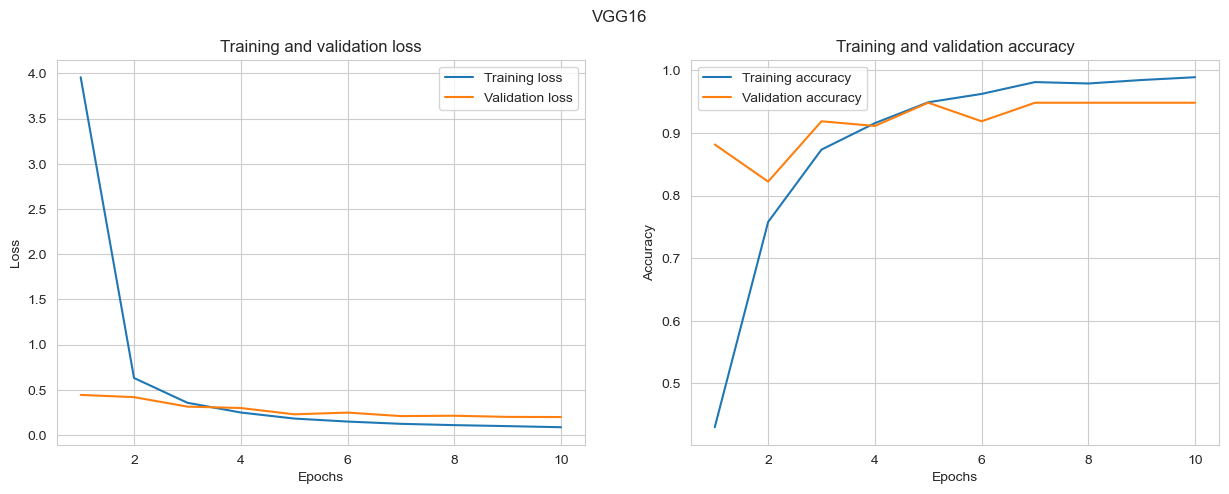

In [147]:
plot_training_history(vgg_16_history, "VGG16")

In [148]:
vgg_16_preds = vgg_16_model.predict(test_gen, verbose=1)
vgg_16_preds = np.argmax(vgg_16_preds, axis=1)

9/9 [==============================] - 10s 1s/step


In [149]:
print(classification_report(test_gen.classes, vgg_16_preds, target_names=classes_names))

              precision    recall  f1-score   support

      cloudy       0.92      0.96      0.94        24
        rain       0.94      1.00      0.97        17
       shine       1.00      0.75      0.86        20
     sunrise       0.91      1.00      0.95        29

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90



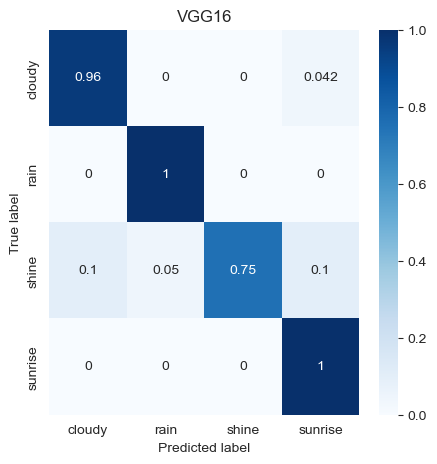

In [150]:
plot_confusion_matrix(test_gen.classes, vgg_16_preds, "VGG16", classes_names)

### VGG16 with augmentated images

In [151]:
vgg_16_aug = VGG16NN()
vgg_16_aug.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_16_aug._name = "VGG16_aug"
vgg_16_aug.build((None, *img_shape))
vgg_16_aug.summary()

Model: "VGG16_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_22 (Flatten)        multiple                  0         
                                                                 
 dense_44 (Dense)            multiple                  6422784   
                                                                 
 dropout_22 (Dropout)        multiple                  0         
                                                                 
 dense_45 (Dense)            multiple                  1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________


In [152]:
history = vgg_16_aug.fit(augmentated_train_gen, validation_data=valid_gen, epochs=epochs, verbose=1)

Epoch 1/12
29/29 [==============================] - 199s 7s/step - loss: 1.7650 - accuracy: 0.5757 - val_loss: 0.4949 - val_accuracy: 0.8222
Epoch 2/12
29/29 [==============================] - 194s 7s/step - loss: 0.3927 - accuracy: 0.8680 - val_loss: 0.2895 - val_accuracy: 0.9037
Epoch 3/12
29/29 [==============================] - 207s 7s/step - loss: 0.2735 - accuracy: 0.9198 - val_loss: 0.2822 - val_accuracy: 0.8889
Epoch 4/12
29/29 [==============================] - 190s 7s/step - loss: 0.2192 - accuracy: 0.9365 - val_loss: 0.2263 - val_accuracy: 0.9333
Epoch 5/12
29/29 [==============================] - 183s 6s/step - loss: 0.1894 - accuracy: 0.9538 - val_loss: 0.2090 - val_accuracy: 0.9556
Epoch 6/12
29/29 [==============================] - 179s 6s/step - loss: 0.1433 - accuracy: 0.9683 - val_loss: 0.1884 - val_accuracy: 0.9556
Epoch 7/12
29/29 [==============================] - 183s 6s/step - loss: 0.1195 - accuracy: 0.9811 - val_loss: 0.1864 - val_accuracy: 0.9481
Epoch 8/12
29

In [156]:
# save_history(history.history, "vgg_16_aug")
vgg_16_aug_history = load_history_from_file("vgg_16_aug")

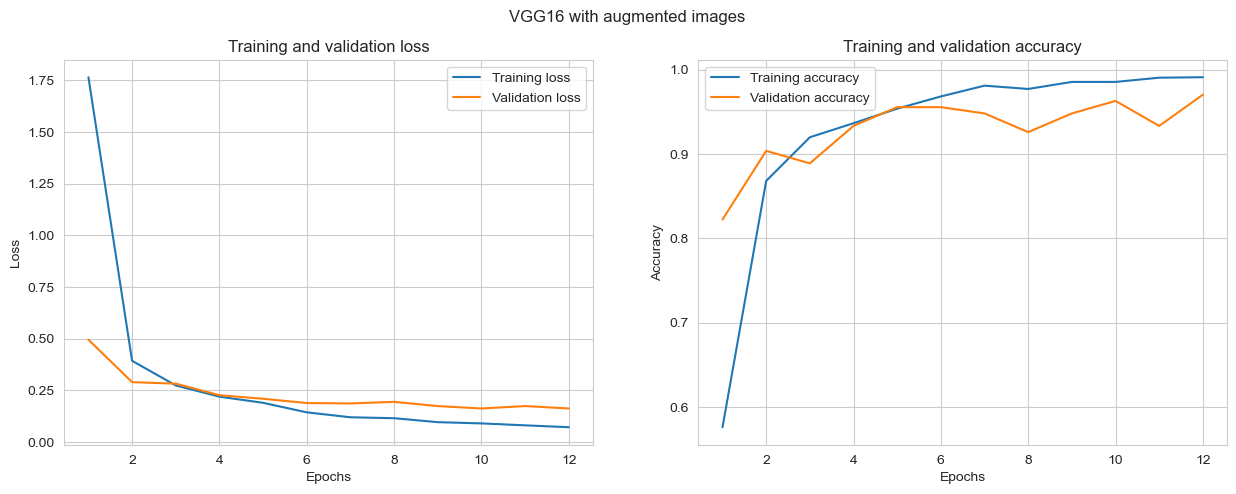

In [159]:
plot_training_history(vgg_16_aug_history, "VGG16 with augmented images")

In [160]:
vgg_16_aug_preds = vgg_16_aug.predict(test_gen, verbose=1)
vgg_16_aug_preds = np.argmax(vgg_16_aug_preds, axis=1)

9/9 [==============================] - 9s 932ms/step


In [161]:
print(classification_report(test_gen.classes, vgg_16_aug_preds, target_names=classes_names))

              precision    recall  f1-score   support

      cloudy       0.92      0.96      0.94        24
        rain       0.94      1.00      0.97        17
       shine       0.81      0.85      0.83        20
     sunrise       1.00      0.90      0.95        29

    accuracy                           0.92        90
   macro avg       0.92      0.93      0.92        90
weighted avg       0.93      0.92      0.92        90



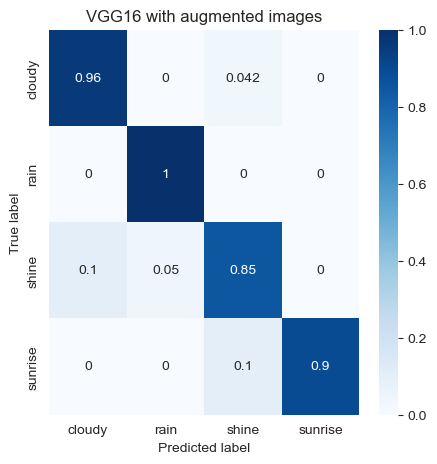

In [162]:
plot_confusion_matrix(test_gen.classes, vgg_16_aug_preds, "VGG16 with augmented images", classes_names)